## TODO


### Imports

In [43]:
import pandas
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [138]:
path = "~/work/data/e"
topic = "t3"
full_path = path + "/" + topic

## Filter

In [139]:
def dropFirstXRows(input, x):
    return input.drop(np.arange(0,x))

In [168]:
produced_df = pandas.read_csv(full_path + "_produced.csv")
start_df = pandas.read_csv(full_path + ".csv")
filtered_df = pandas.read_csv(full_path + "_filtered.csv")
warnings_df = pandas.read_csv(full_path + "_warnings.csv")
modelchange_df = pandas.read_csv(full_path + "_modelchange.csv")

elementsToDrop = 10000
produced_df = dropFirstXRows(produced_df,elementsToDrop)
start_df = dropFirstXRows(start_df,elementsToDrop)
filtered_df = dropFirstXRows(filtered_df,elementsToDrop)

#drop changes before first element
modelchange_df = modelchange_df[modelchange_df.iloc[:,0] >= produced_df.iloc[0][2]]

# drop endtime in warning before first element
warnings_df = warnings_df[warnings_df.iloc[:,6] >= produced_df.iloc[0][2]]

### Helper

In [141]:
def plotDistribution(data):
    plt.rcParams['figure.figsize'] = [100,20]
    plt.scatter(np.arange(1,len(data) + 1,1), data, s = 1)
    #plt.yscale("log")
    #plt.ylim(0,50)
    plt.show()
    
    sorted = np.sort(data)
    plt.yscale("log")
    plt.plot(np.arange(0,1,1 / (len(sorted))), sorted)
    plt.show()

In [142]:
def extractAvgMedStdMinMaxFromArray(diff):
    plotDistribution(diff)
    return np.average(diff), np.median(diff), np.std(diff), np.min(diff), np.max(diff)

### Information on the time difference between the arival time of records for all 3 topics

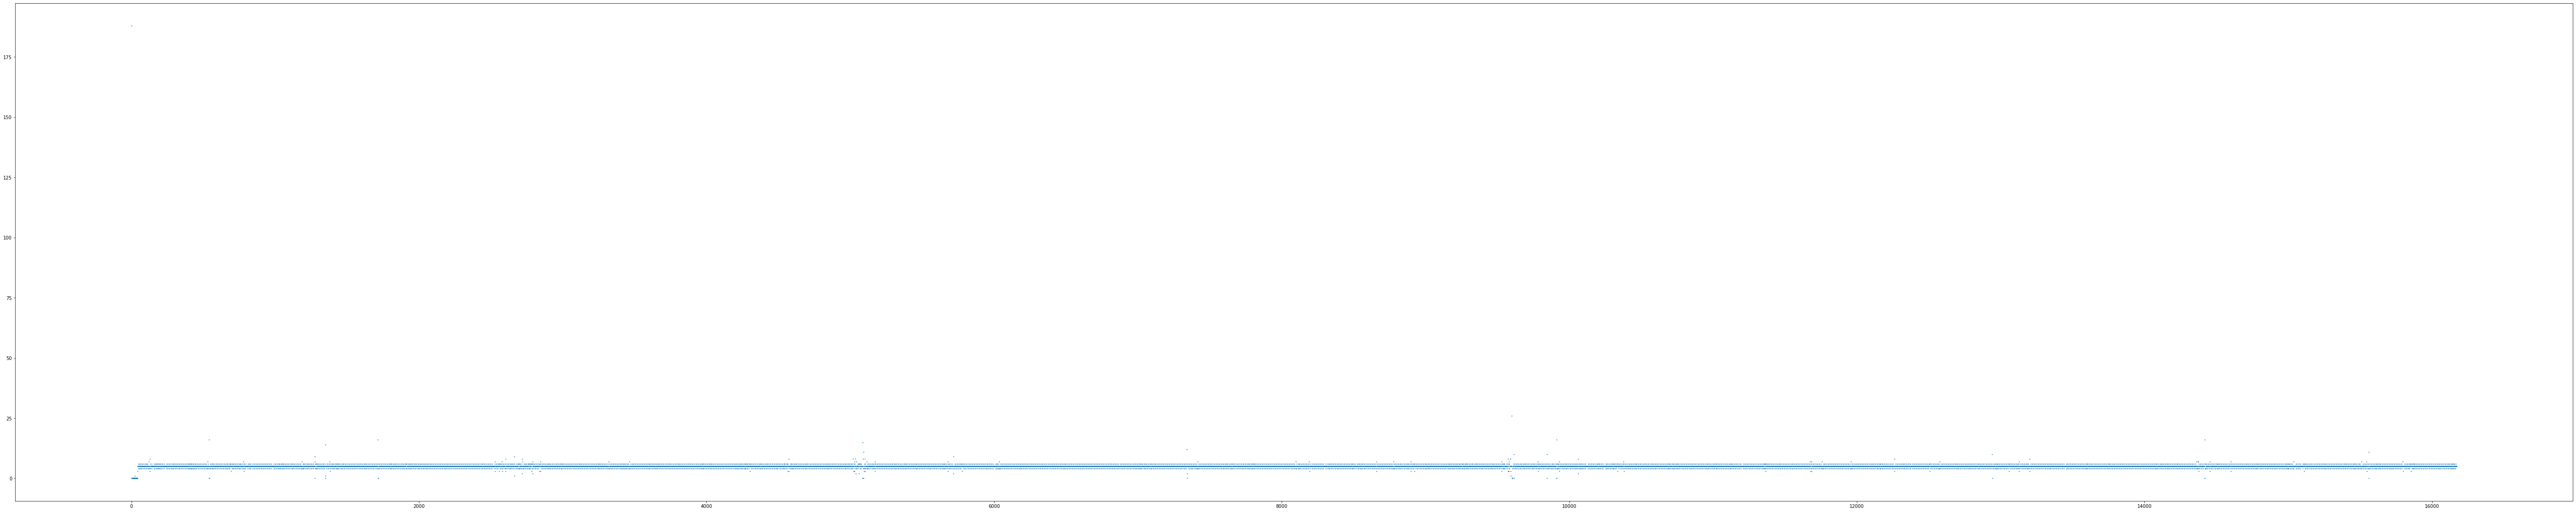

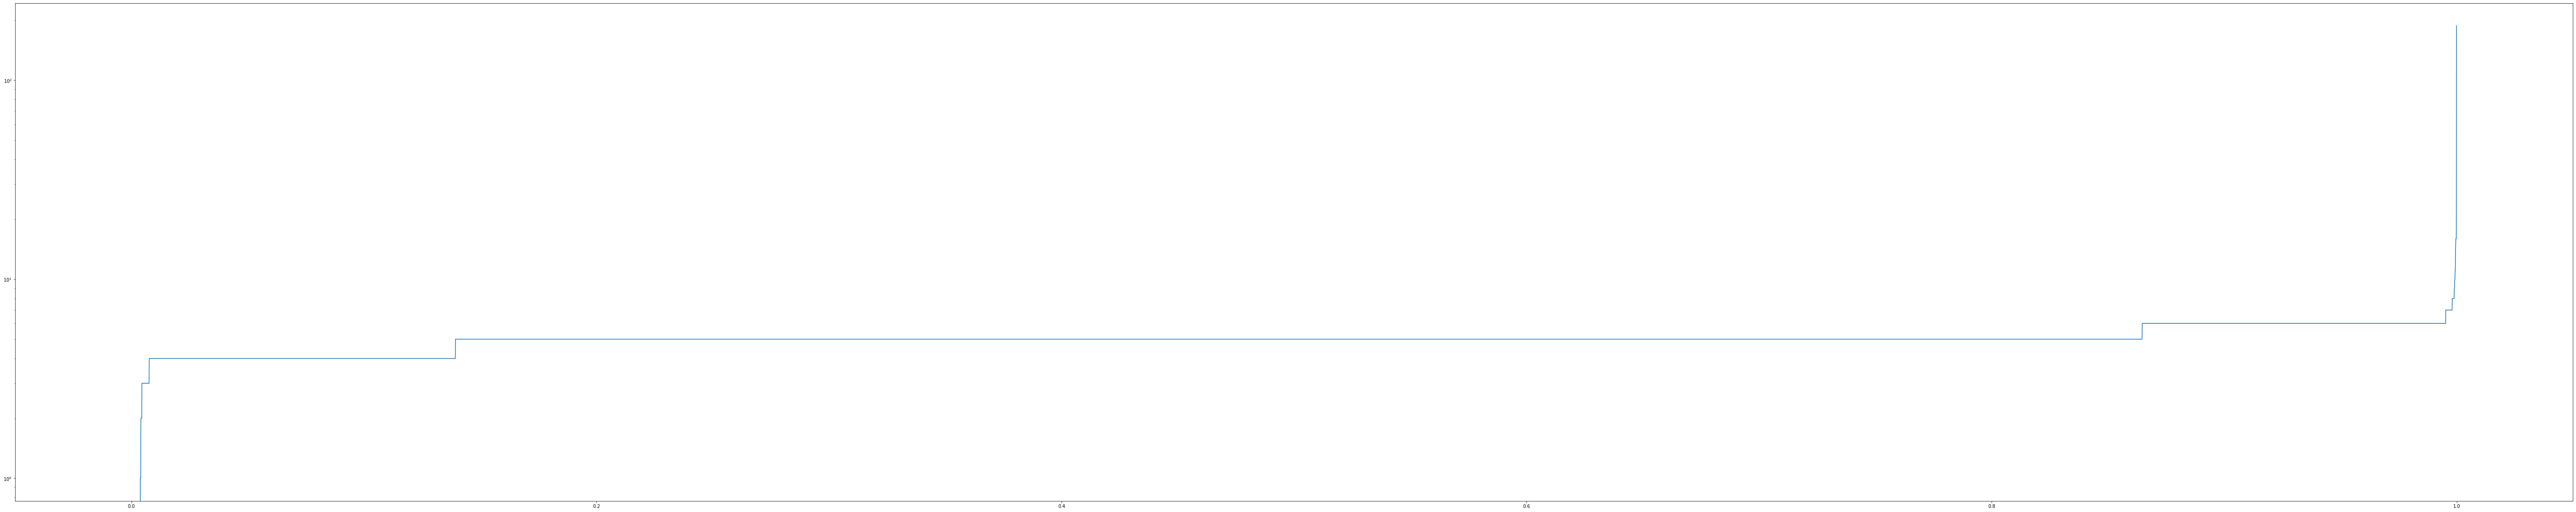

produced:
Got in average every 5.00 ms new data, with median 5.00, and std = 1.60, further min was 0 and max 188




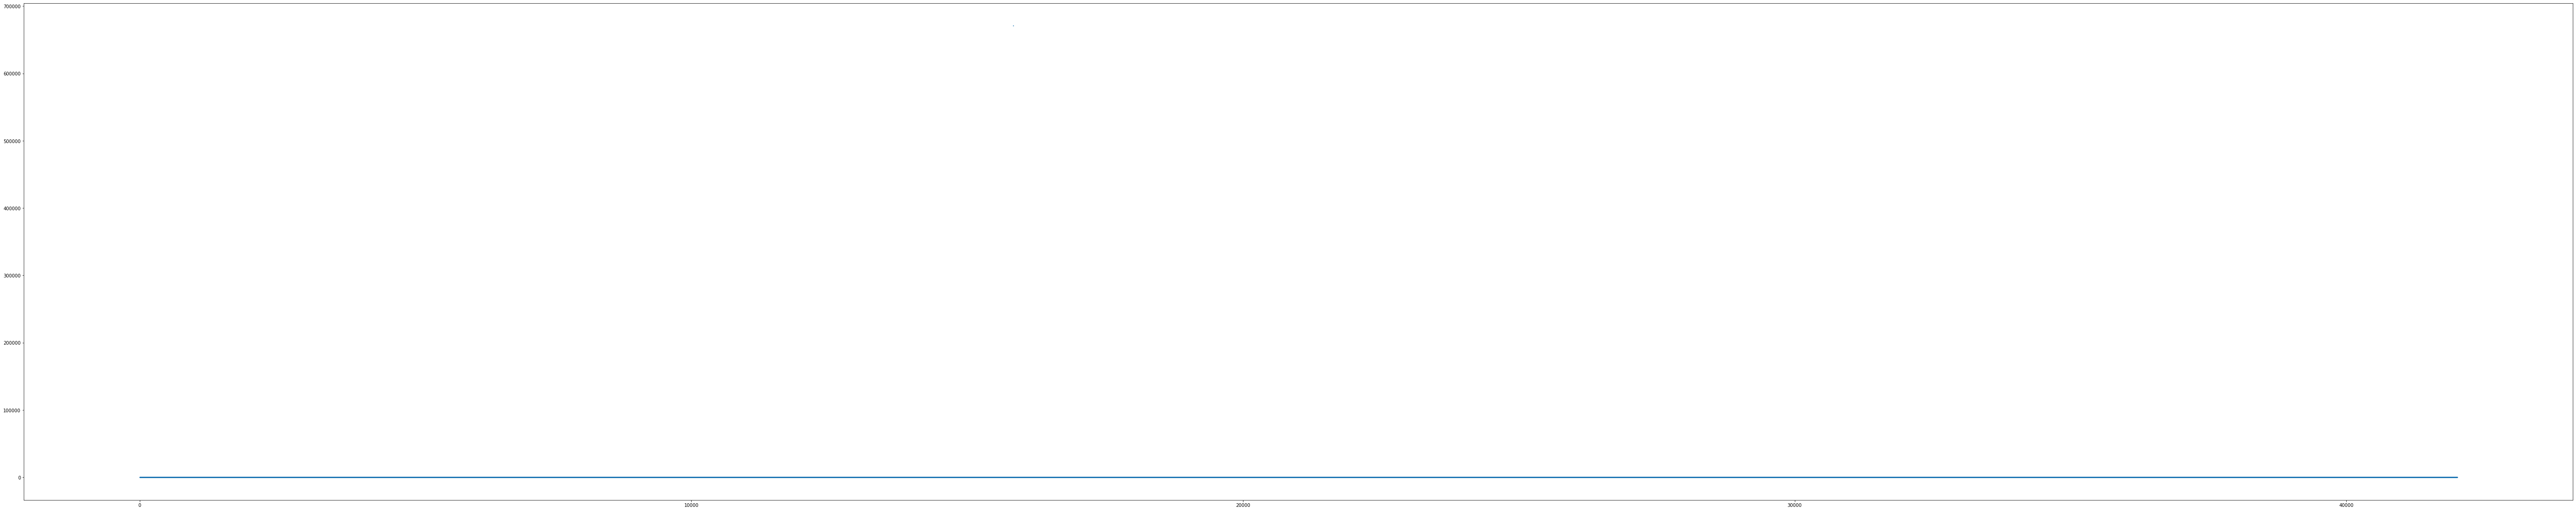

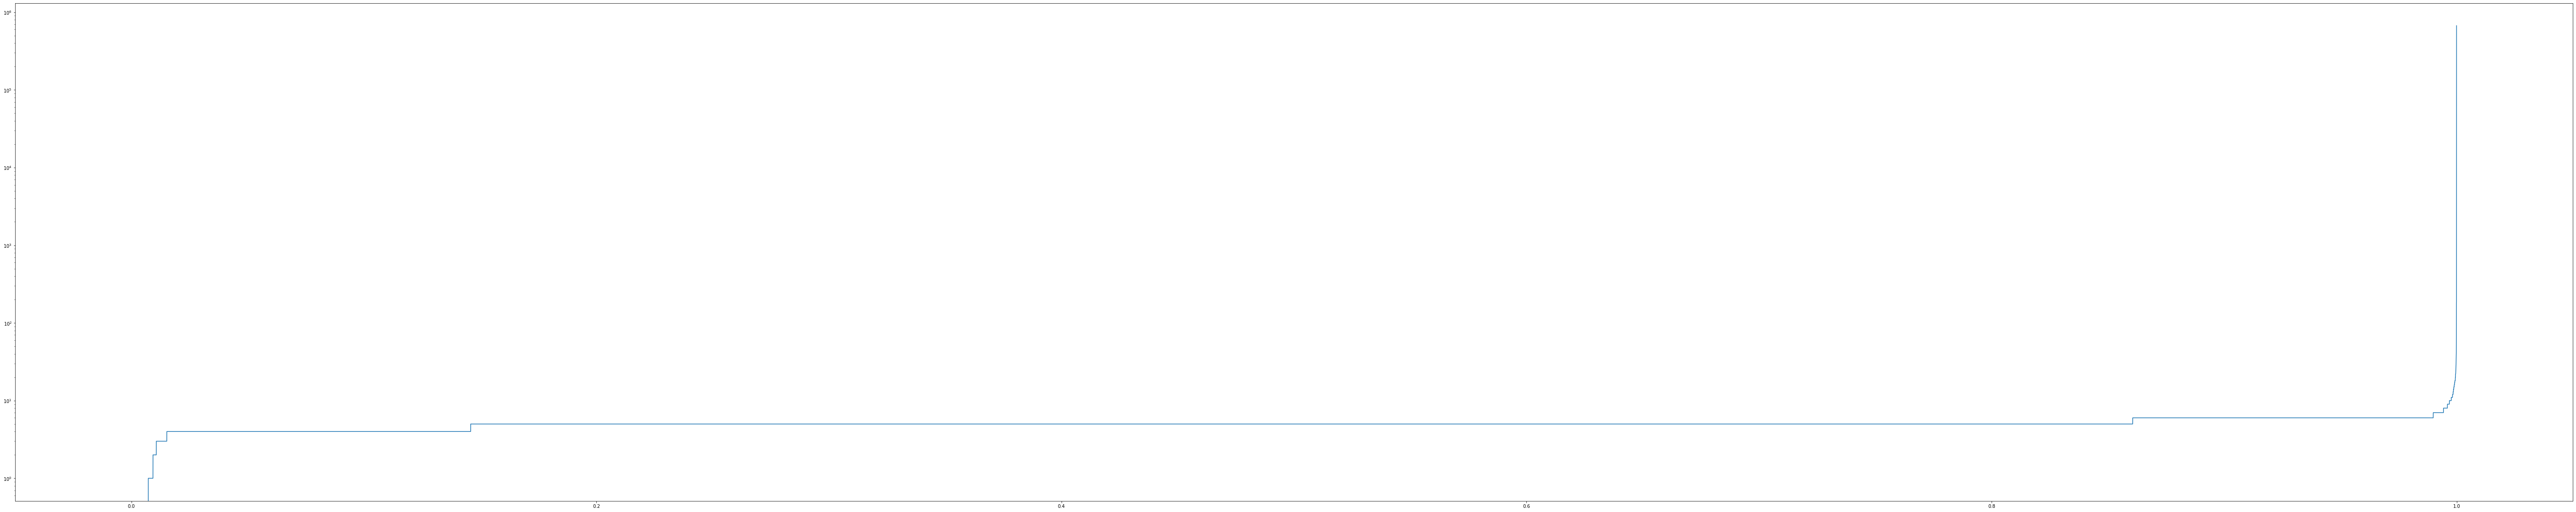

produced received:
Got in average every 20.97 ms new data, with median 5.00, and std = 3273.72, further min was 0 and max 671005




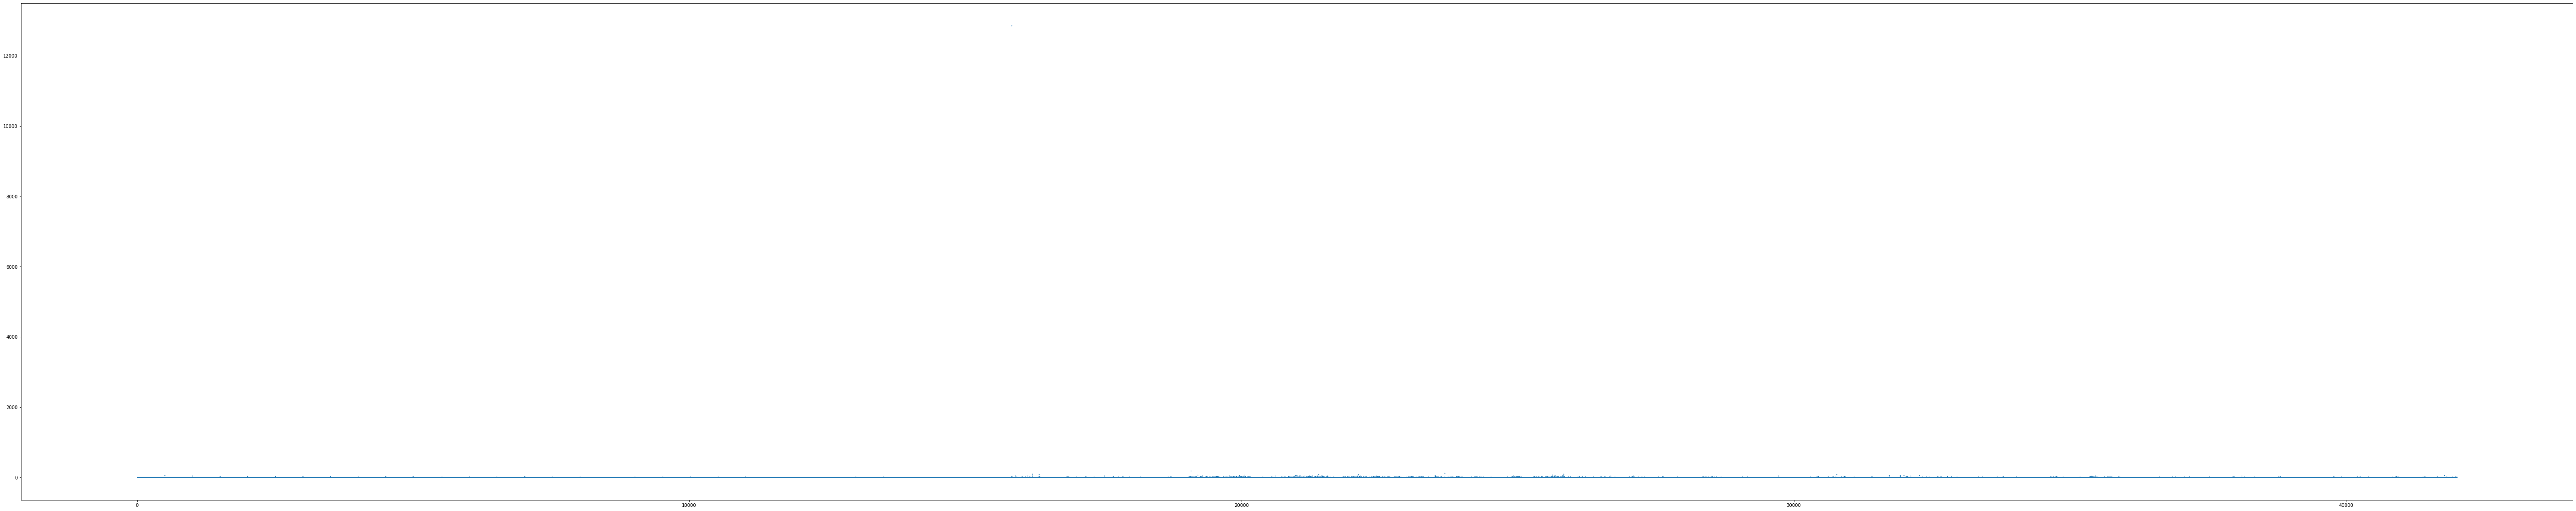

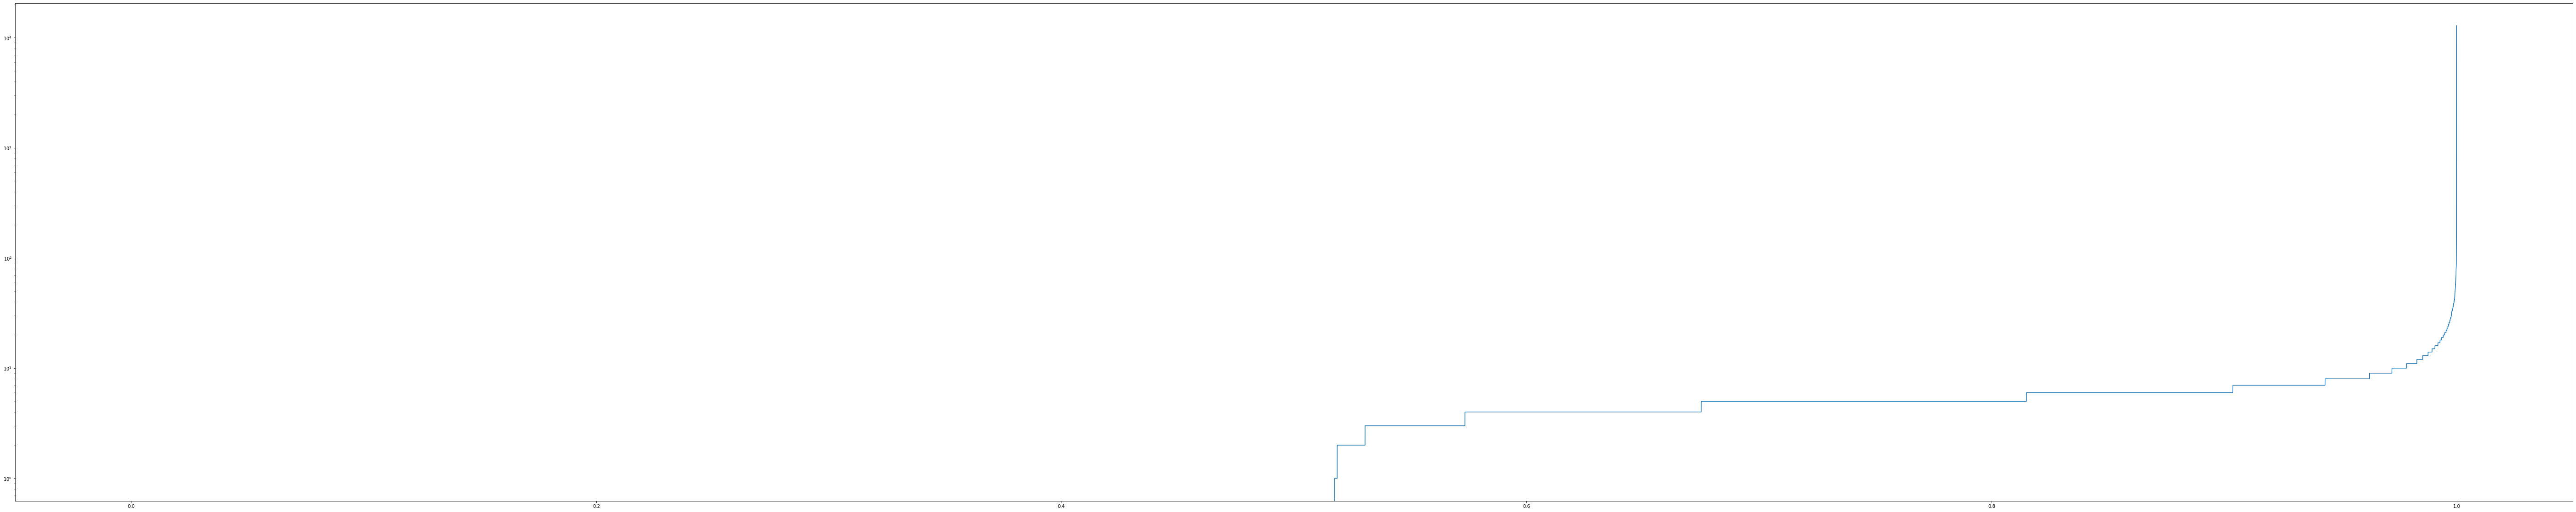

filtered:
Got in average every 3.08 ms new data, with median 0.00, and std = 62.84, further min was 0 and max 12855




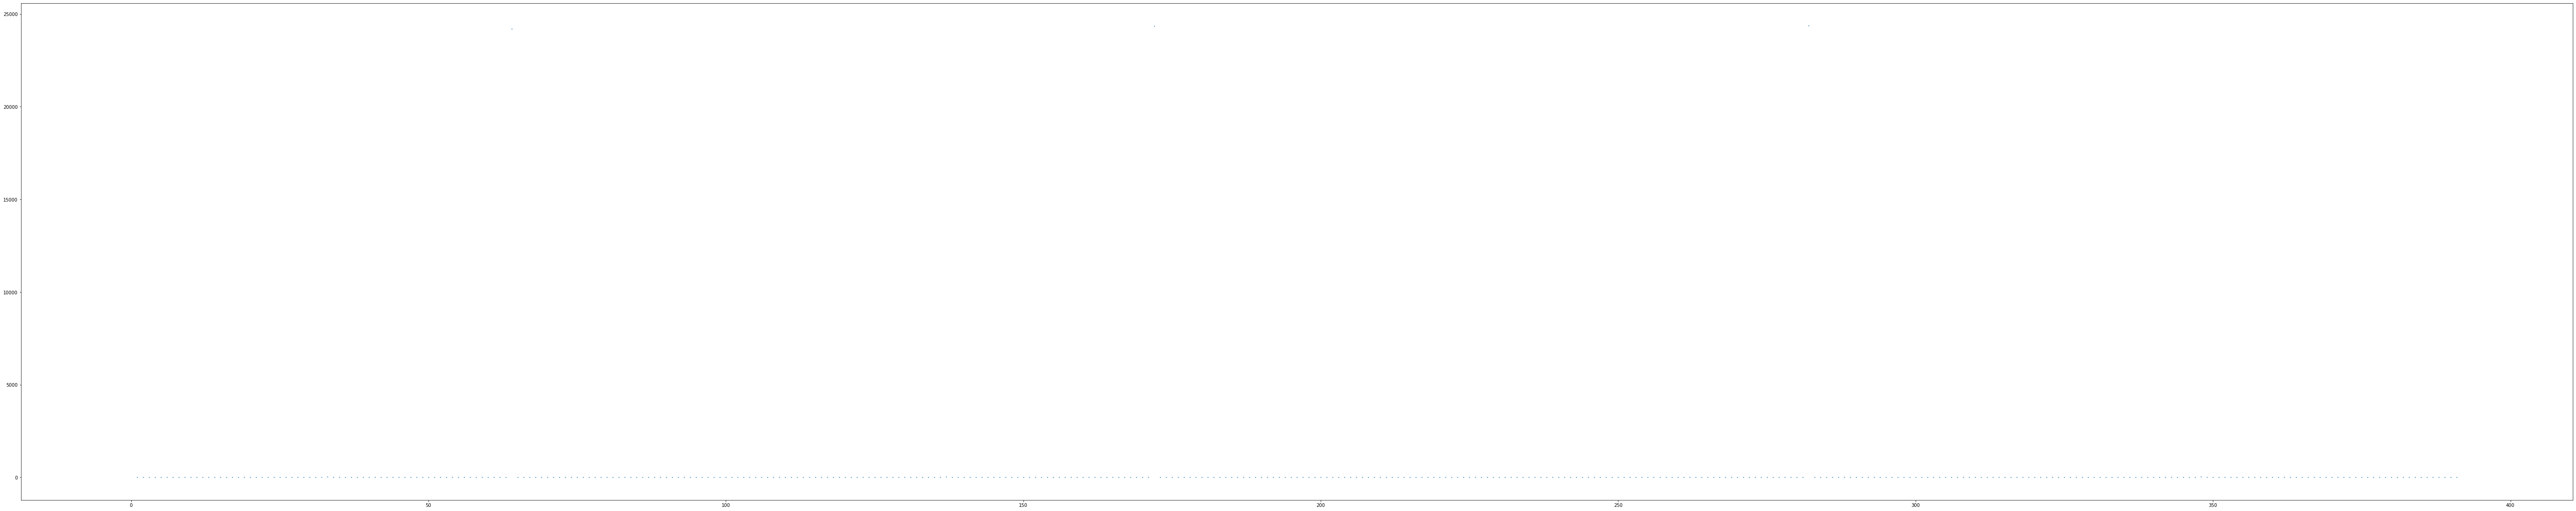

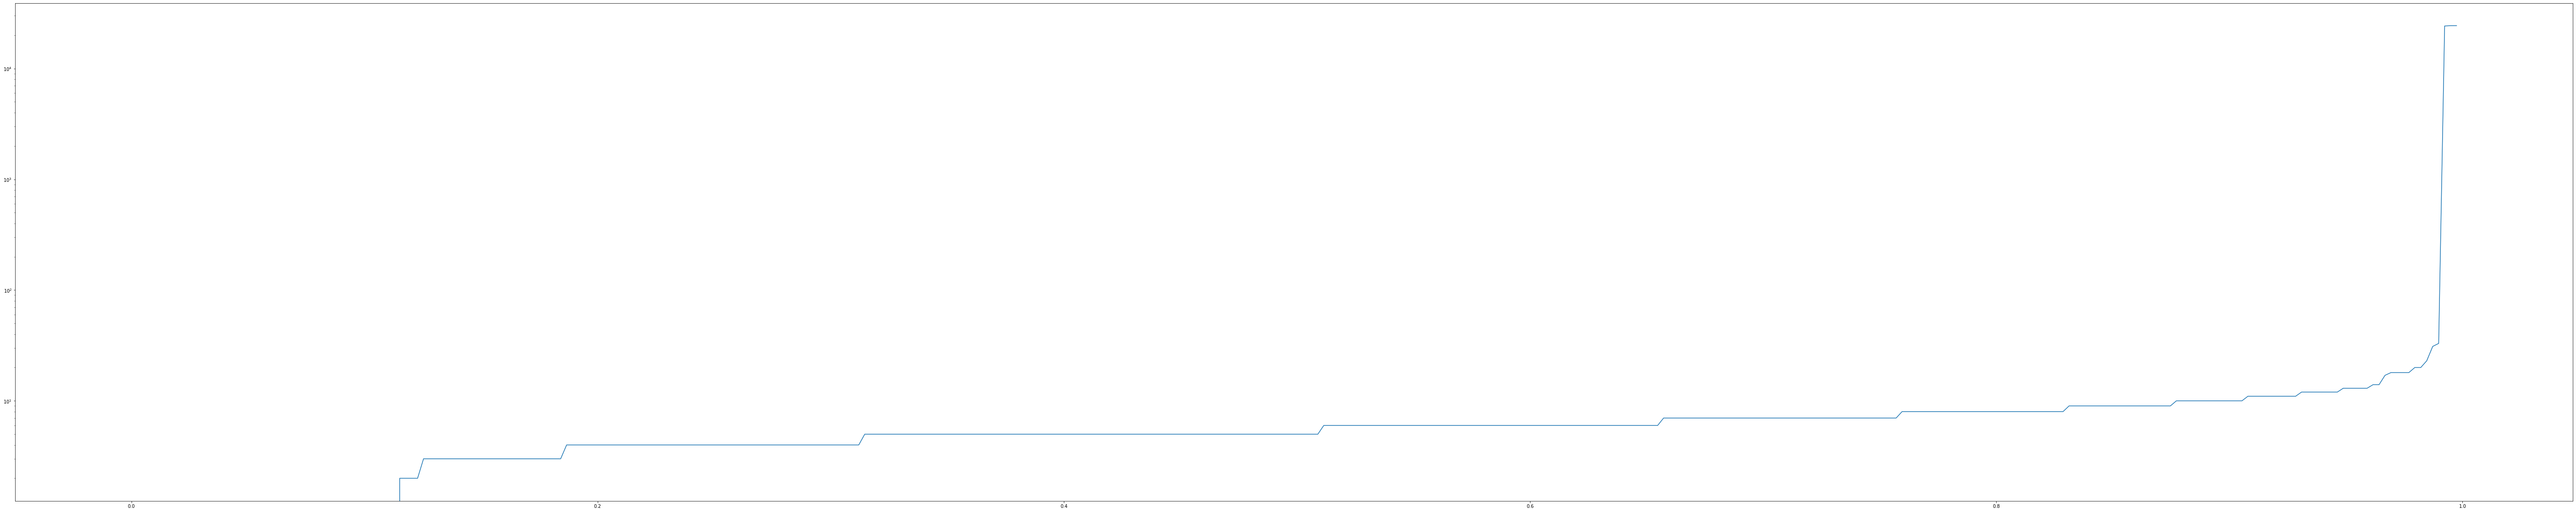

Got in average every 192.42 ms new data, with median 5.00, and std = 2121.33, further min was 0 and max 24376




In [143]:
def avgMedStdArivalTime(df, column):
    df = df.to_numpy()[:,column].astype(int)
    #print(df)
    diff = df[1:,]-df[:-1,]
          
    return extractAvgMedStdMinMaxFromArray(diff)
    
def getArivalInfos():
    text = "%s:\nGot in average every %.2f ms new data, with median %.2f, and std = %.2f, further min was %d and max %d\n\n"
    print(text %("produced", *avgMedStdArivalTime(produced_df, 3)))
    print(text %("produced received", *avgMedStdArivalTime(start_df, 3)))
    print(text %("filtered", *avgMedStdArivalTime(filtered_df, 0)))
    print(text %("warning", *avgMedStdArivalTime(warnings_df, 0)))
    
getArivalInfos()

## Check Produced

### How long does it take until a produced record is acknowledged by kafka

[0 0 0 ... 0 0 0]


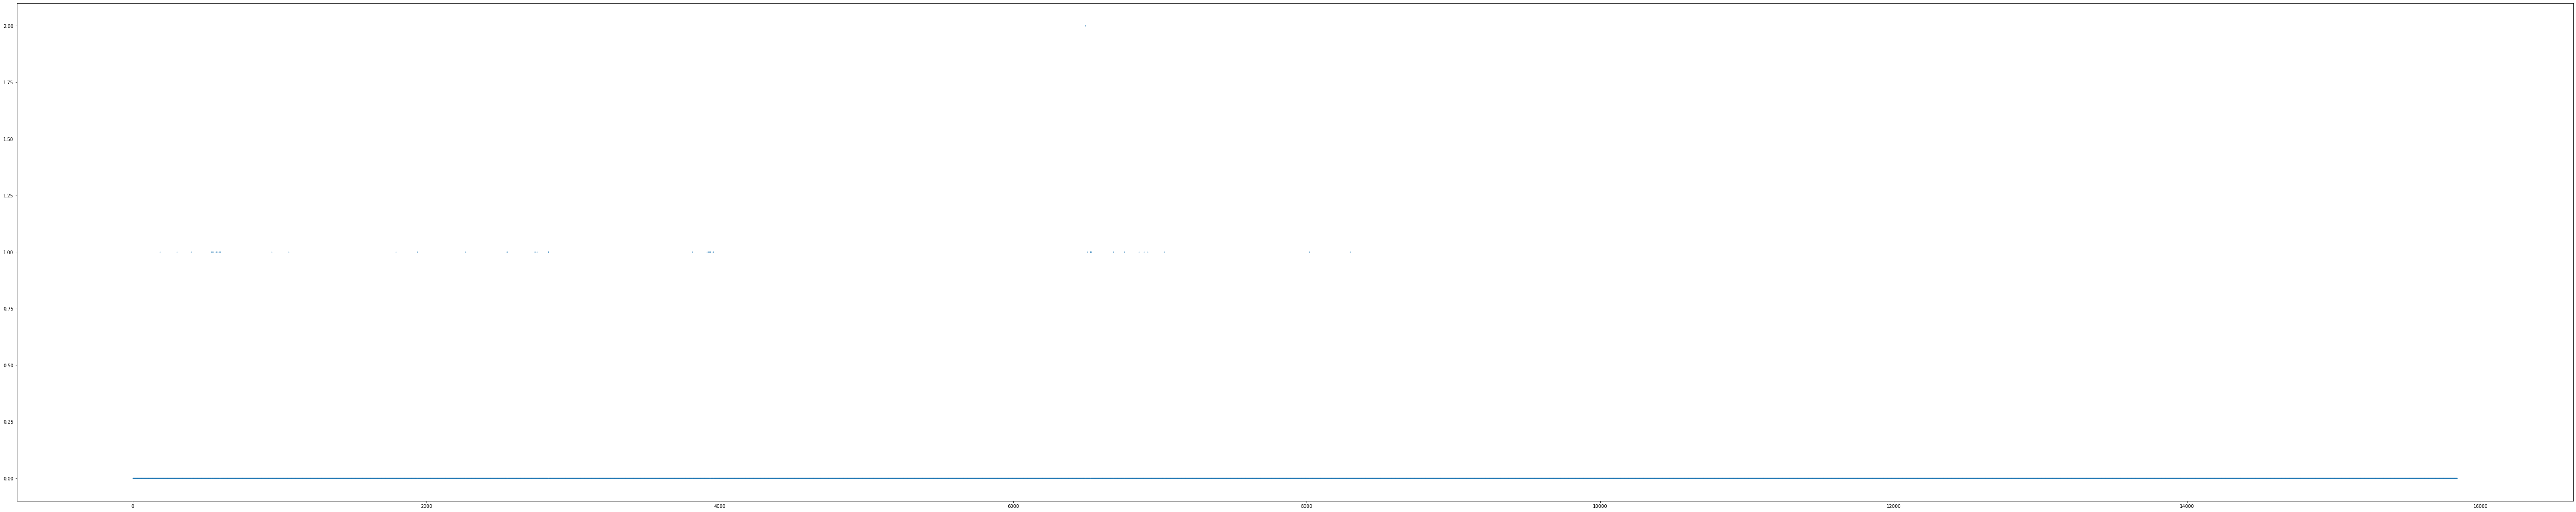

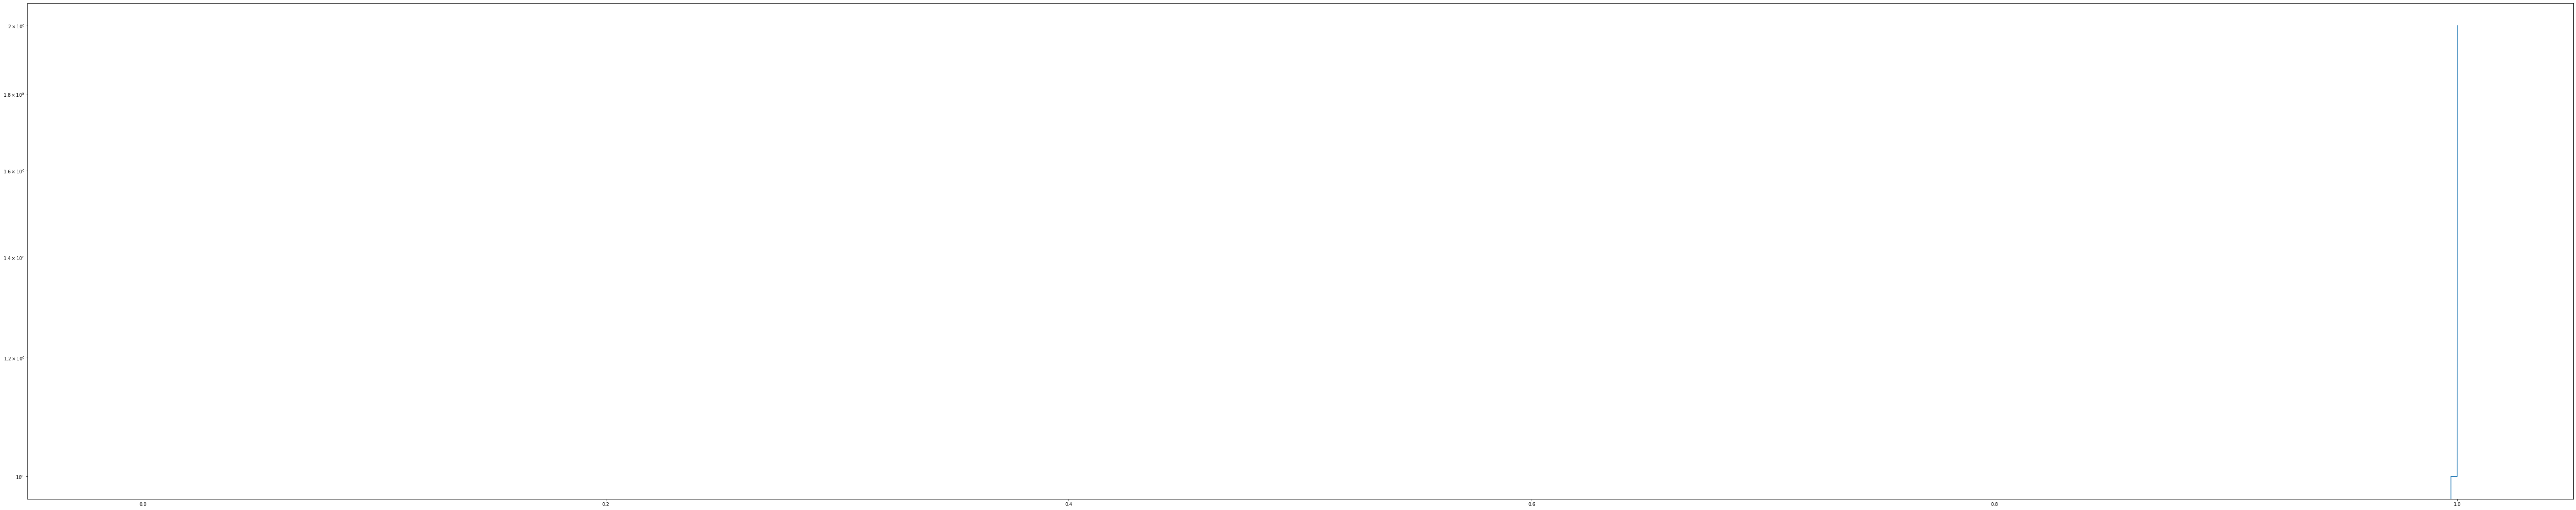

Produced data was received by Kafka after: avg = 0.00 ms; median 0.00 ms; std = 0.05 ms, further min was 0 ms and max 2 ms


In [129]:
def kafkaAck(df):
    ack = df.to_numpy()[:,1].astype(int)
    send = df.to_numpy()[:,3].astype(int)
    diff = send - ack
    print(diff)
    return extractAvgMedStdMinMaxFromArray(diff)
    
print("Produced data was received by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %kafkaAck(produced_df))

### check validity of produced data

In [130]:
def validate(df):
    df = df.to_numpy()
    lastRow = df[0]
    error = False
    
    l = len(df)
    
    f = IntProgress(min=0, max=100) # instantiate the bar
    display(f)
    i = 0
    
    for x in df[1:]:
        
        i += 1
        cp = int((i / float(l)) * 100)
        
        if(cp != f.value):
            f.value = cp
            
        if(np.sum(x >= lastRow) != 4):
            error = True
            print("Error:")
            print(lastRow)
            print(x)
        if(lastRow[0] + 1 != x[0]):
            print("Offset %i increased not by 1" %lastRow[0])
            
        lastRow = x
    if(not error):
        print("Valid")
        
validate(produced_df)

IntProgress(value=0)

Valid


## Data loss produced to filter

In [131]:
def calcDataLoss(df1, df1OffsetColumn, df2, df2OffsetColumn):
    df1Offsets = df1.to_numpy()[:,df1OffsetColumn].astype(int)
    df2Offsets = df2.to_numpy()[:,df2OffsetColumn].astype(int)
    
    errors = {}
        
    count = {}
    
    for x in df1Offsets:
        
        count[x] = 0

        
        #count = np.sum(df2Offsets == x)
        
        #if(count != 1):
        #    errors[count] = errors.get(count, 0) + 1
        
    for x in df1Offsets:
        count[x] = count[x] + 1
        
    for k, v in count.items():
        if v != 1:
            errors[count] = errors.get(count, 0) + 1
    
    out = "Received records "
    losses = False
    for k, v in errors.items():
        out += "%ix for %i times; " %(k,v)
        losses = True
    
    if(losses):
        print(out)
    else:
        print("The expected data was received exactly once.")
    
calcDataLoss(produced_df, 0, filtered_df, 3)    

The expected data was received exactly once.


## Latency produced - warning

[1.60001839e+12 0.00000000e+00]
A
[1.60001841e+12 1.00000000e+01]
B
[1.60001841e+12 0.00000000e+00]
A
[1.60001843e+12 1.00000000e+01]
B
[1.60001844e+12 0.00000000e+00]
A
[1.60001846e+12 1.00000000e+01]
B
[1.60001846e+12 0.00000000e+00]
A
Didn't match all recognized changes! With 0 weren't matched:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

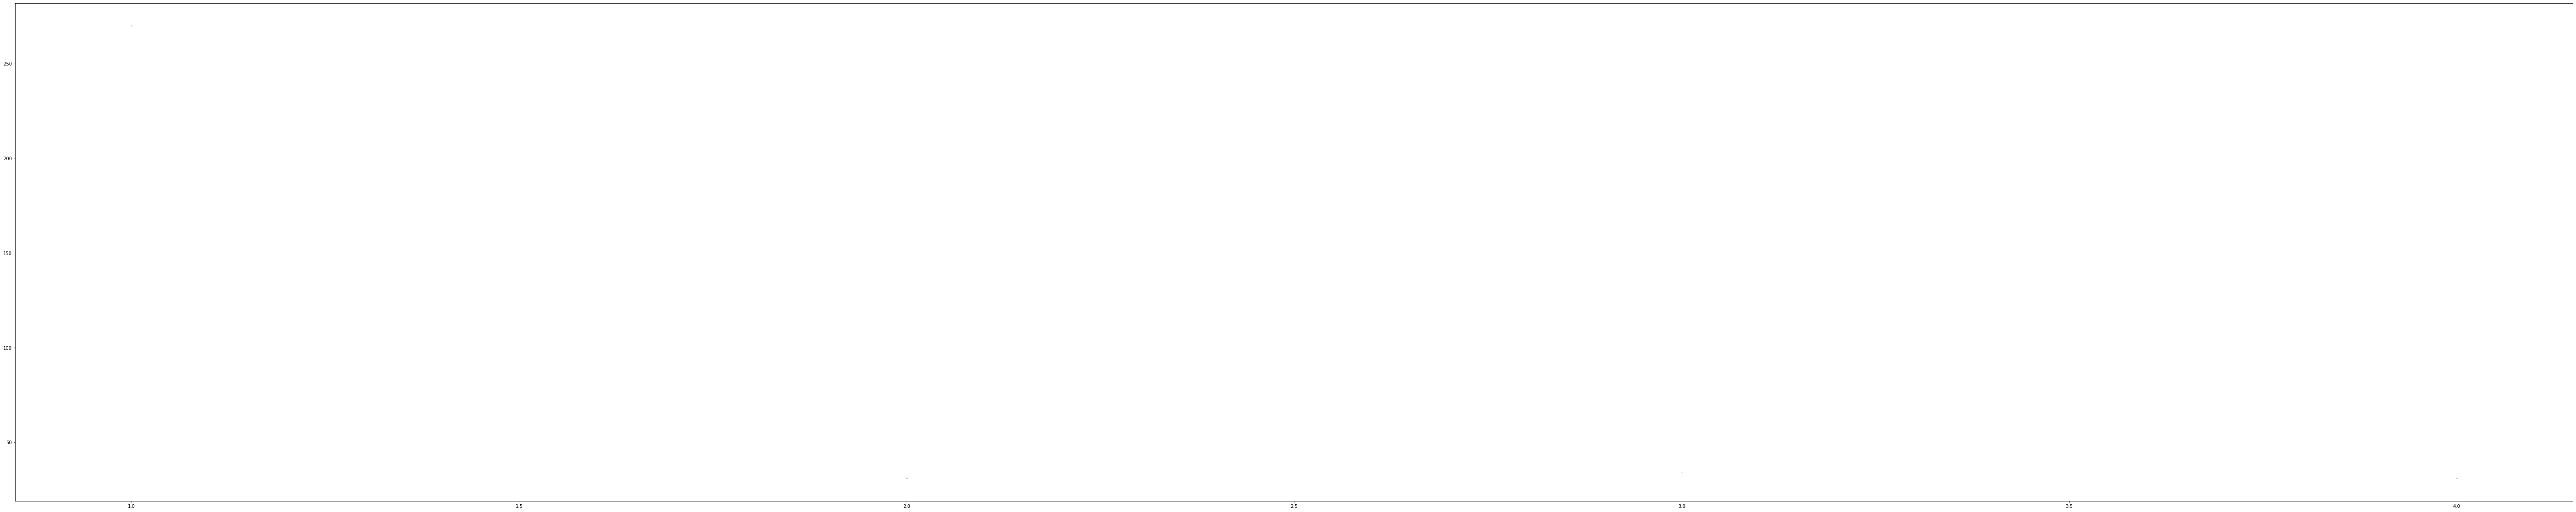

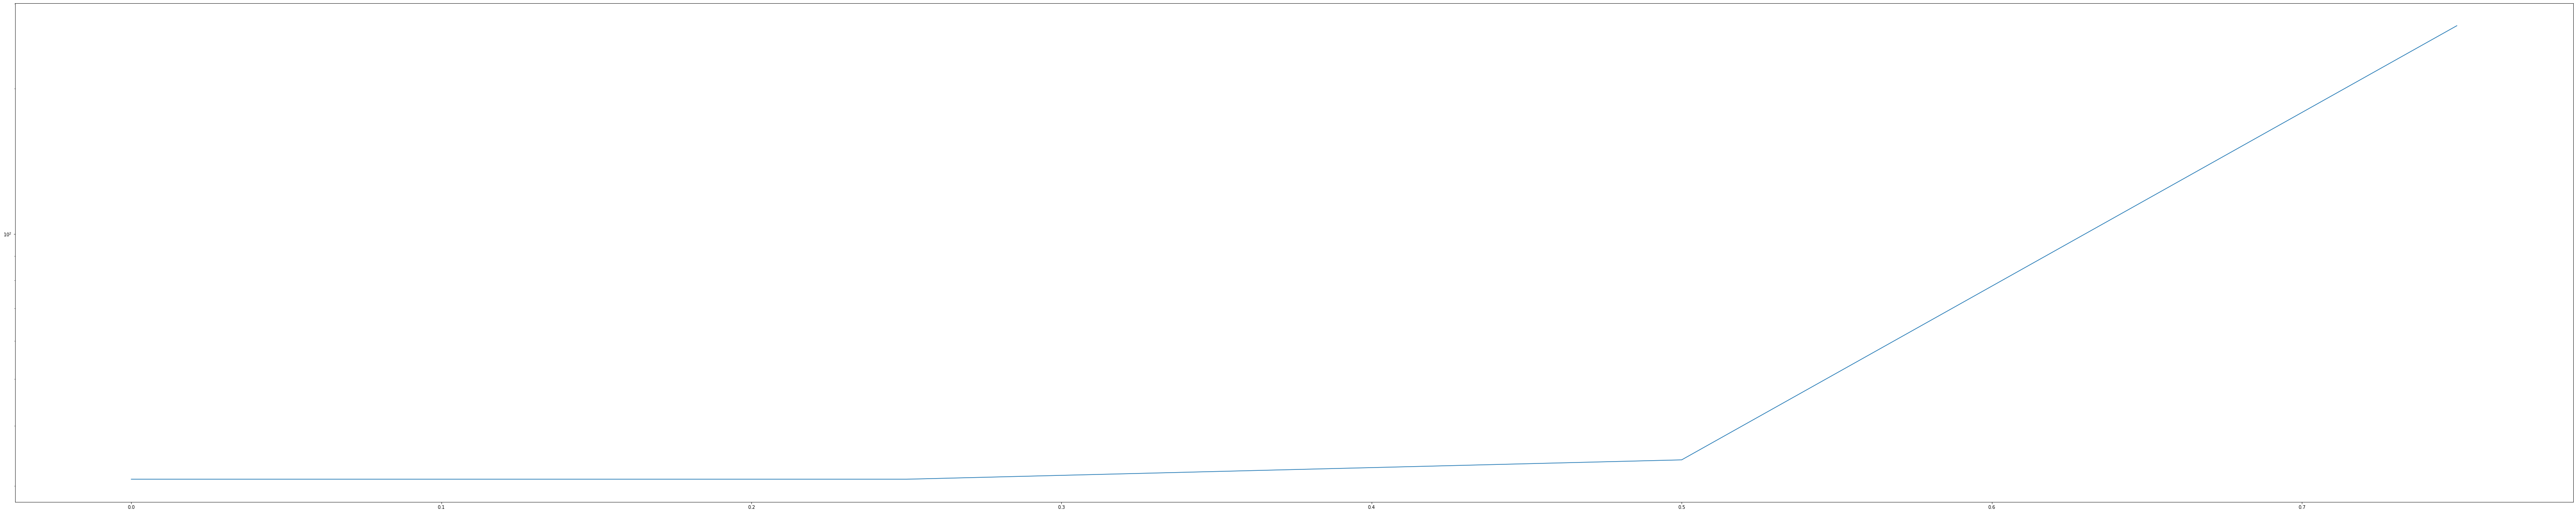

Anomalies were detected by Kafka after: avg = 91.50 ms; median 32.50 ms; std = 103.06 ms, further min was 31 ms and max 270 ms


In [170]:
def calcLatencyProduceWarning(modelchange_df, warnings_df):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        print(x)
        if int(x[1]) == 0 :
            print("A")
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            print("B")
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df))

def calcLatencyProduceWarning(modelchange_df, warnings_df, amplitude, periodLength):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        if x[1] == amplitude and x[2] == periodLength:
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df, 3, 1000))